# ONDELETTES

## Téléchargement des librairies

In [1]:
import pandas as pd
import numpy as np
import os

# ACP
import sklearn.decomposition as sd
import sklearn.preprocessing as sp

# Hierarchical clustering
import scipy.cluster.hierarchy as sch
#Wavelet
import pywt
from pywt import wavedec
from statsmodels.robust import mad
# LOF
import sklearn.neighbors as sn
# Isolation Forest
import sklearn.ensemble as se
#One Class SVM
import sklearn.svm as ssvm

# Plot et Display
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sb
sb.set()
sb.set_style("darkgrid", {"axes.facecolor": ".9"})

## Lecture des données

On lit directement les données nettoyées et dont la longueur a été modifiée à 1024.

In [2]:
import pickle
with open('X_1024', 'rb') as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    X_1024 = mon_depickler.load()
n=len(X_1024) #nb de signaux

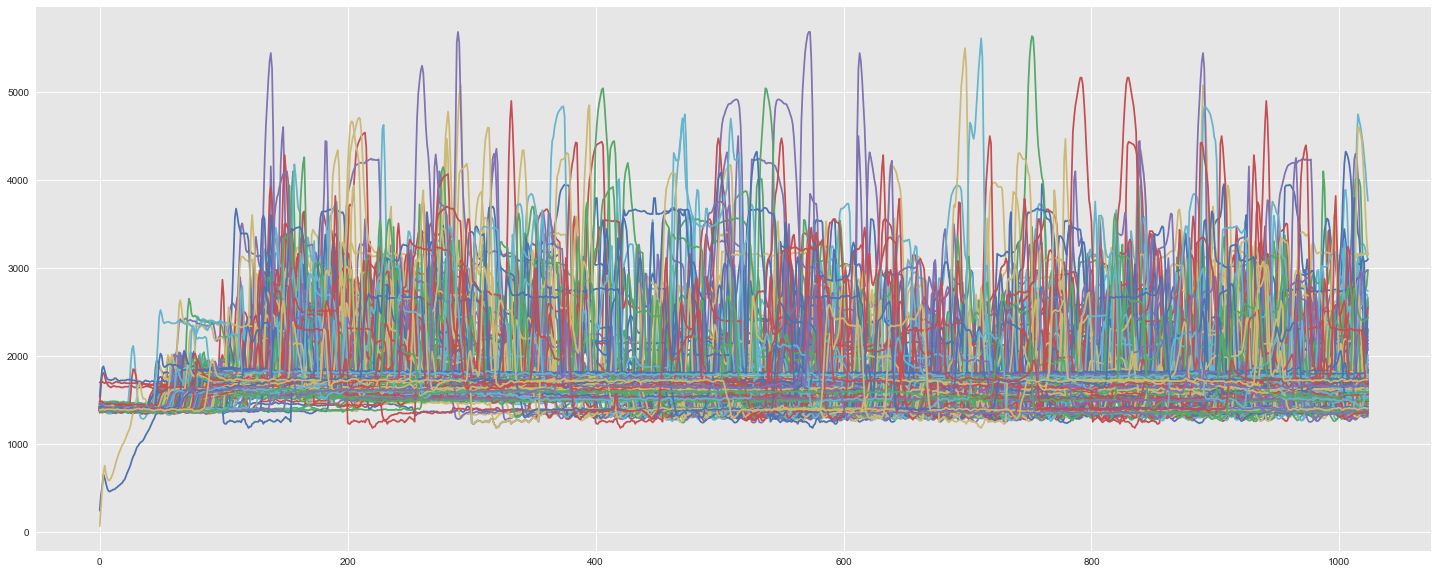

In [3]:
fig = plt.figure(figsize=(25, 10))
for x in X_1024:
    plt.plot(x)

## Décomposition en ondelettes

On effectue la décomposition en ondelettes pour chaque signal et on récupère 2 tableaux de coefficients, l'un avec tous les coefficients de chaque signal, l'autre avec les coefficients seuillés. On pourra réaliser la décomposition en ondelettes seuillés avec les modes `hard`, `soft`, `greater` ou `less`.

In [4]:
wf = 'db2' # 'haar' ou 'db2'

Coeff = []
TCoeff = []

for x in X_1024:
    #Apply wavelet decomposition
    coeffs = pywt.wavedec(x,wf,level=8)  #Niveau 8
    coeffs_flatten = np.hstack(coeffs)
    Coeff.append(coeffs_flatten)
    # Compute universal Threshold http://jseabold.net/blog/2012/02/23/wavelet-regression-in-python/
    sigma = mad(coeffs[-1])
    uthresh = sigma*np.sqrt(2*np.log(1024))
    # Apply Threshold on 4 first levels
    coeffs_thresh = [pywt.threshold(c, uthresh, mode="hard") if j<=3 else c for j,c in enumerate(coeffs[::-1])]
    coeffs_thresh_flatten = np.hstack(coeffs_thresh[::-1])
    TCoeff.append(coeffs_thresh_flatten)
    
Coeff = np.array(Coeff)
TCoeff = np.array(TCoeff)
print(Coeff.shape, TCoeff.shape)
print(np.sum(Coeff!=0), np.sum(TCoeff!=0))

(425, 1041) (425, 1041)
440470 93267


**Q** : QUEL MODE DE SEUILLAGE ?

### Choix des coefficients

In [5]:
#Coefficient de niveau 7 : 
Coeff7=Coeff[:,128:]
#Coefficient de niveau 1 à 6 : 
CoeffA6=Coeff[:,:128]
#Coefficient de niveau 1 à 4 : 
CoeffA4=Coeff[:,:16]

## Analyse en composantes principales sur les coefficients d'ondelettes

### Fonctions d'affichage

In [6]:
def plot_var_ACP(X_acp) :
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,2,1)
    ax.bar(range(10), acp.explained_variance_ratio_[:10]*100, align='center', color='grey', ecolor='black')
    ax.set_xticks(range(10))
    ax.set_ylabel("Variance")
    ax.set_title("Pourcentage de variance expliquée \n des premières composantes", fontsize=20)

    ax = fig.add_subplot(1,2,2)
    box = ax.boxplot(X_acp[:, 0:10])
    ax.set_title("Distribution des premières composantes", fontsize=20)
    plt.show()
    
def plot_proj_ACP(X_acp, axe_1=0, axe_2=1, etiq=True) :
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    dict_color = {True : "blue", False : "red"}

    for x, y, s in zip(X_acp[:,axe_1], X_acp[:,axe_2], range(n)) :
        ax.plot(x,y,marker=".", color=dict_color[s < 300]) #300 : longueur liste apprentissage
        if etiq :
            ax.text(x, y, str(s))
       
    ax.set_title("Projection des invididus sur les \n  deux premières composantes", fontsize=20)

    legend_elements = [Line2D([0], [0], marker='.', color='blue', label='Série du jeu d\'apprentissage', markersize=10, linewidth=0),
                       Line2D([0], [0], marker='.', color='red', label='Série du jeu de test', markersize=10, linewidth=0)]

    ax.legend(handles=legend_elements)

    plt.show()
    

### ACP des coefficients d'ondelettes

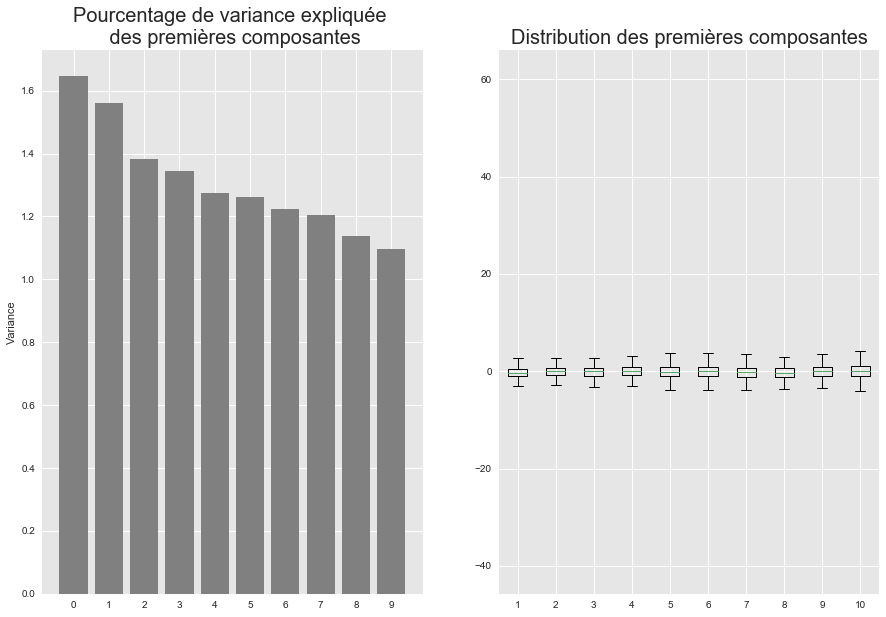

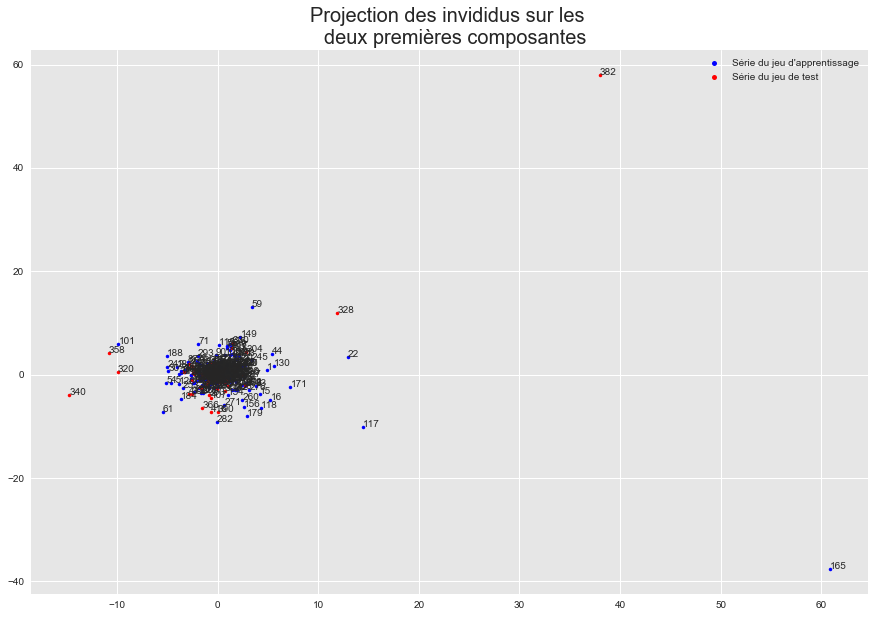

In [7]:
acp = sd.PCA()
X_acp_ond = acp.fit_transform(sp.scale(Coeff))
plot_var_ACP(X_acp_ond)
plot_proj_ACP(X_acp_ond)

### Ondelettes de niveau le plus fin J=7 

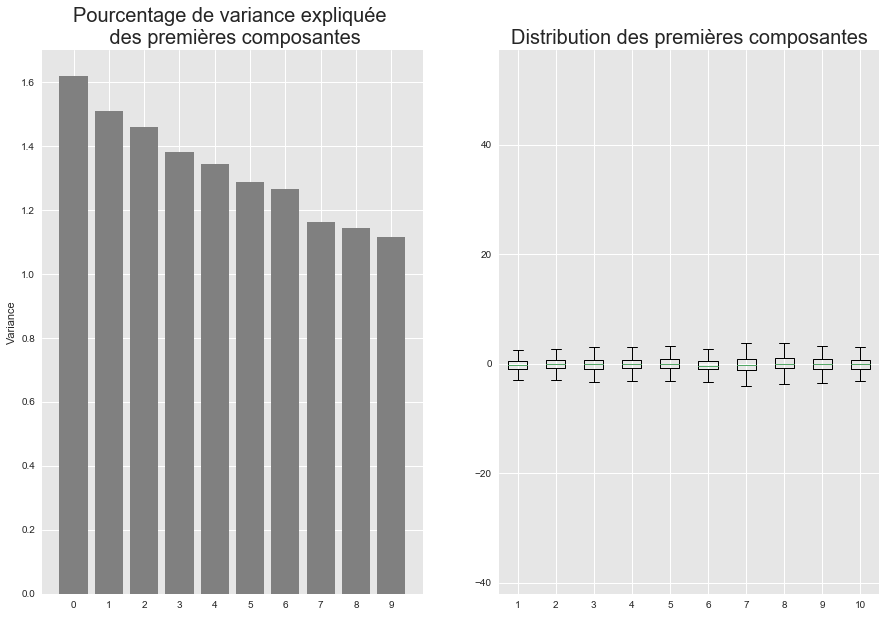

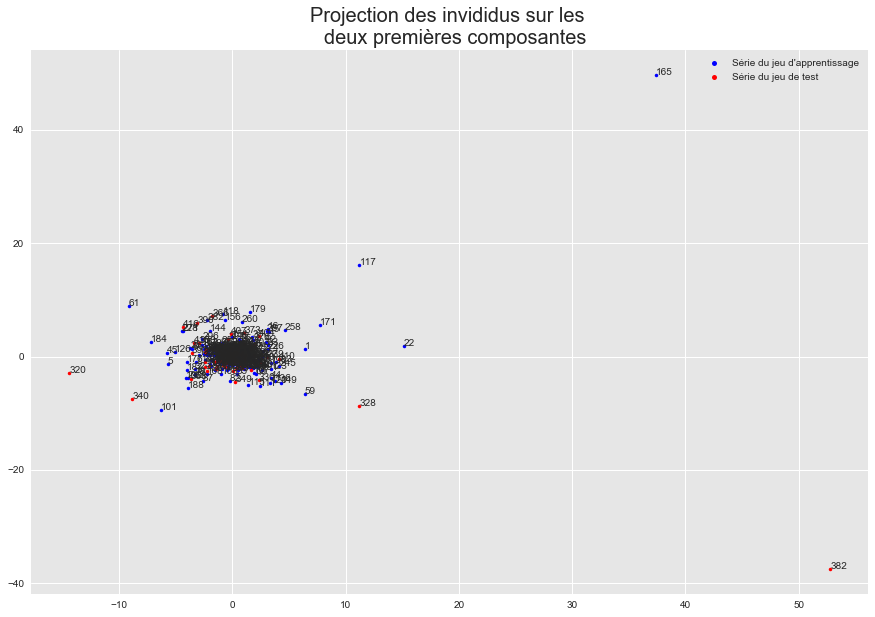

In [8]:
acp = sd.PCA()
X_acp_ond7 = acp.fit_transform(sp.scale(Coeff7))
plot_var_ACP(X_acp_ond7)
plot_proj_ACP(X_acp_ond7)

### ACP des coefficients d'ondelettes de niveau 1 à 6

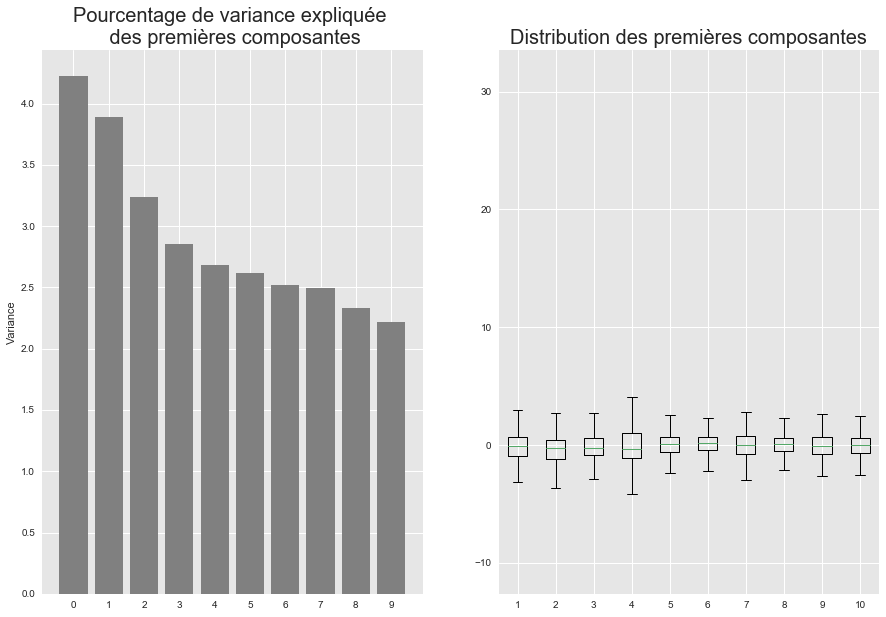

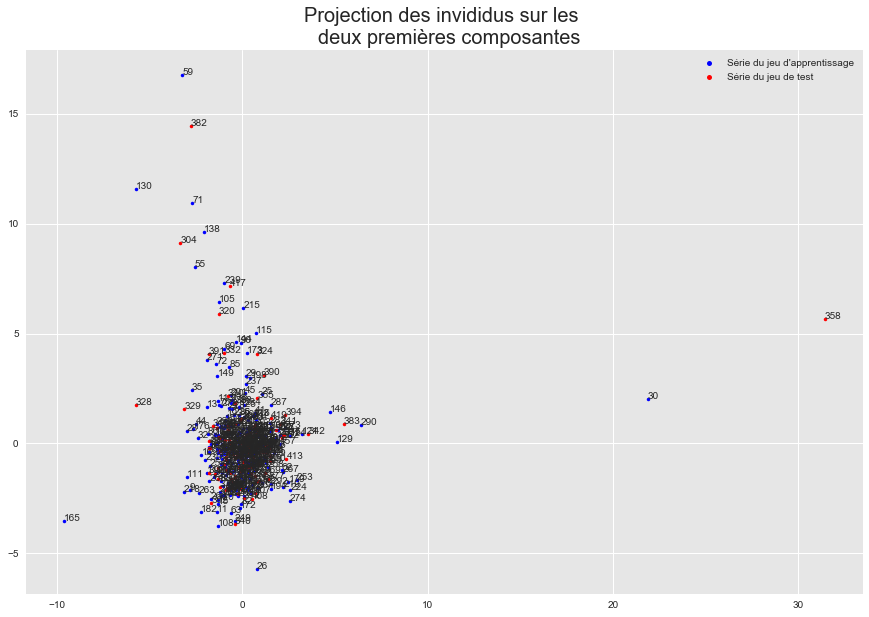

In [9]:
acp = sd.PCA()
X_acp_ondA6 = acp.fit_transform(sp.scale(CoeffA6))
plot_var_ACP(X_acp_ondA6)
plot_proj_ACP(X_acp_ondA6)

### ACP des coefficients d'ondelettes de niveau 1 à 4

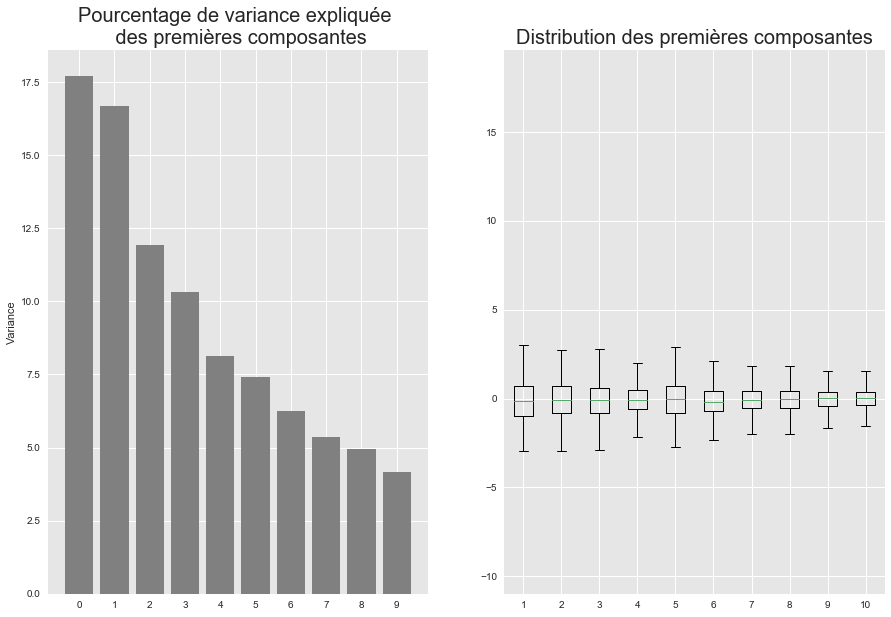

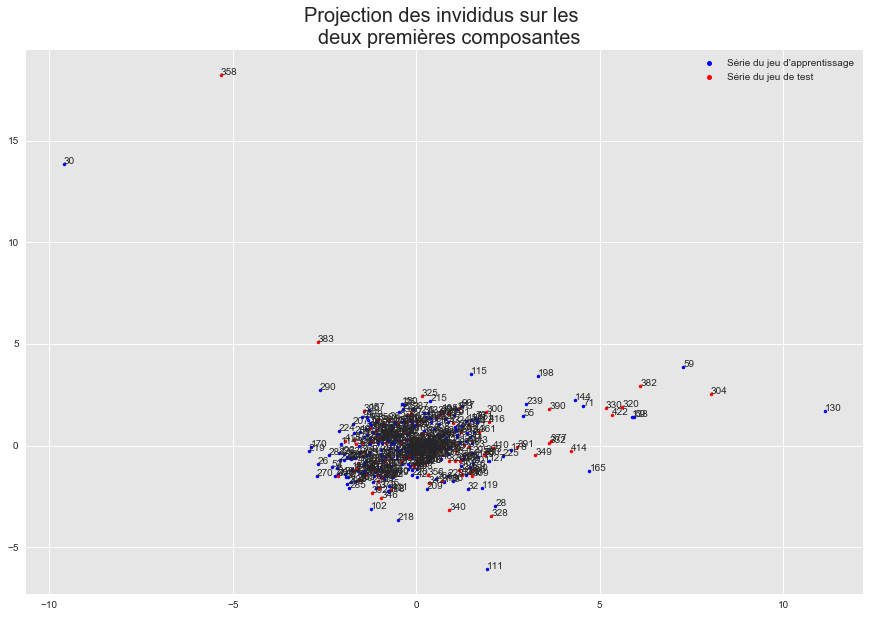

In [10]:
acp = sd.PCA()
X_acp_ondA4 = acp.fit_transform(sp.scale(CoeffA4))
plot_var_ACP(X_acp_ondA4)
plot_proj_ACP(X_acp_ondA4)

### ACP des coefficients seuillés

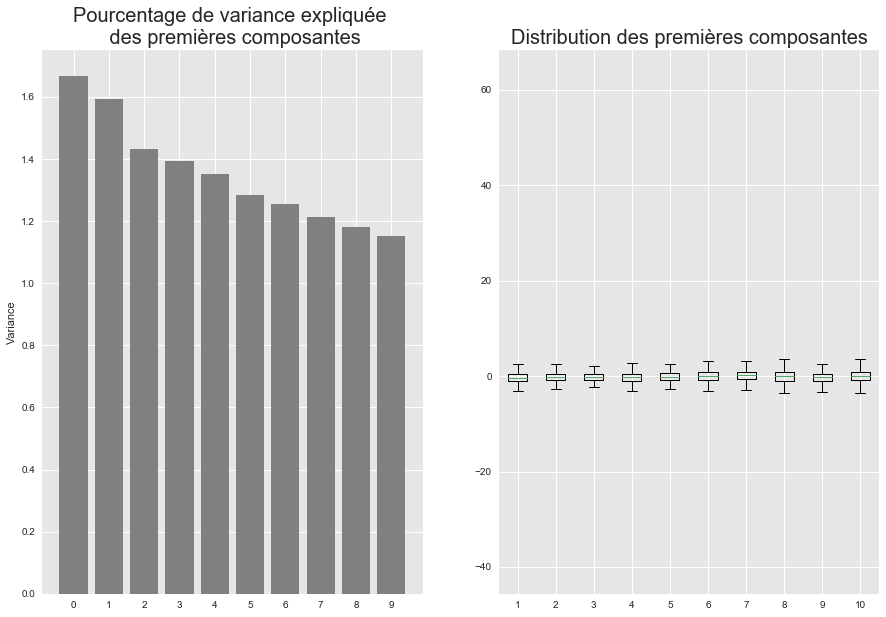

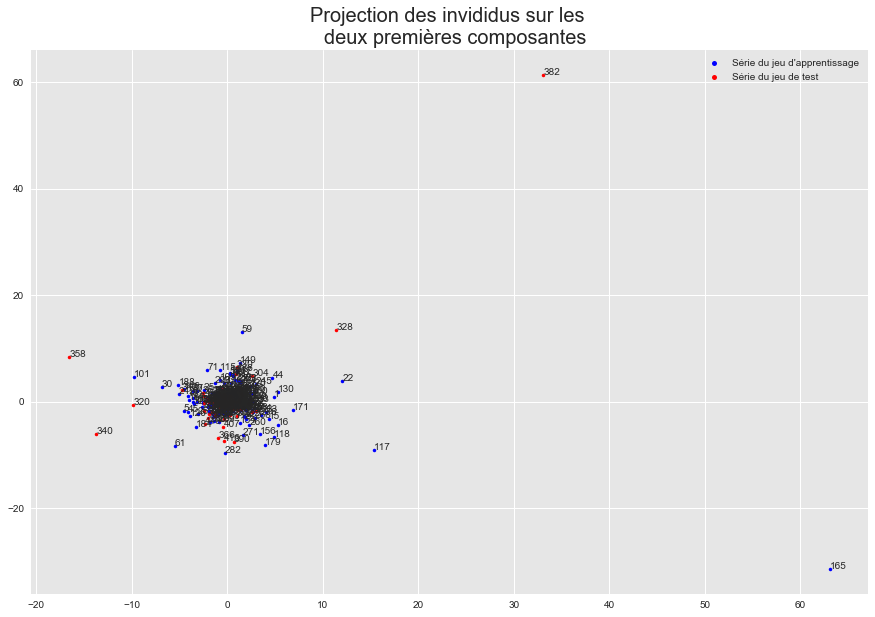

In [11]:
acp = sd.PCA()
X_acp_ondT = acp.fit_transform(sp.scale(TCoeff))
plot_var_ACP(X_acp_ondT)
plot_proj_ACP(X_acp_ondT)

## Classification ascendante hierarchique

### Fonction d'affichage

In [12]:
def CAH(Coeff):
    Z = sch.linkage(Coeff, 'single')
    C = np.array([c[0] for c in sch.cut_tree(Z,5)])
    CT = pd.DataFrame(list(C), columns=["HCA_cluster"])
    return Z,CT

def plot_dendrogram(Z):
    fig = plt.figure(figsize=(25, 10))
    sch.dendrogram( Z, p=20, leaf_rotation=45.,leaf_font_size=15, truncate_mode="level")  # font size for the x axis labels
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    plt.show()

Q :DANS `dendogram`, QUEL CHOIX DE P (nb de niveaux pour l'arbre)? 

### CAH sur tous les coefficients d'ondelettes

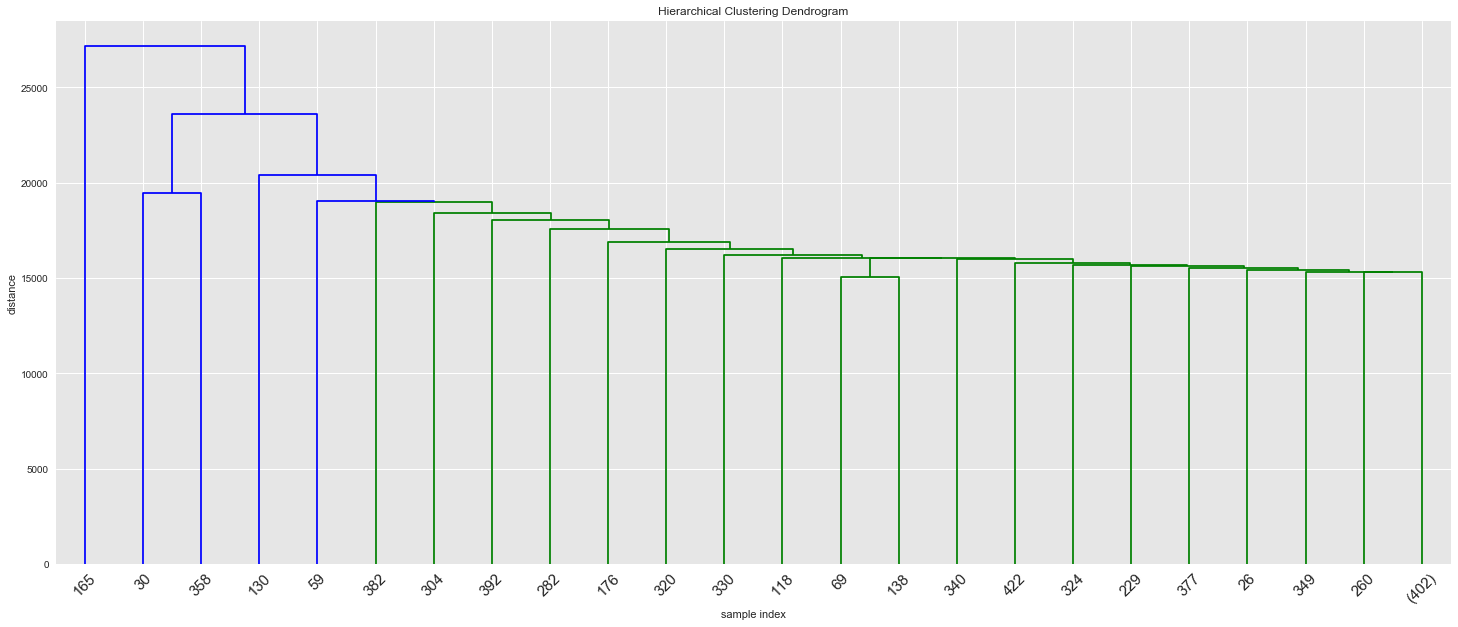

In [13]:
Z_CAH_ond,CT_CAH_ond = CAH(Coeff)
plot_dendrogram(Z_CAH_ond)

### CAH sur les coefficients d'ondelettes de niveau le plus fin J=7

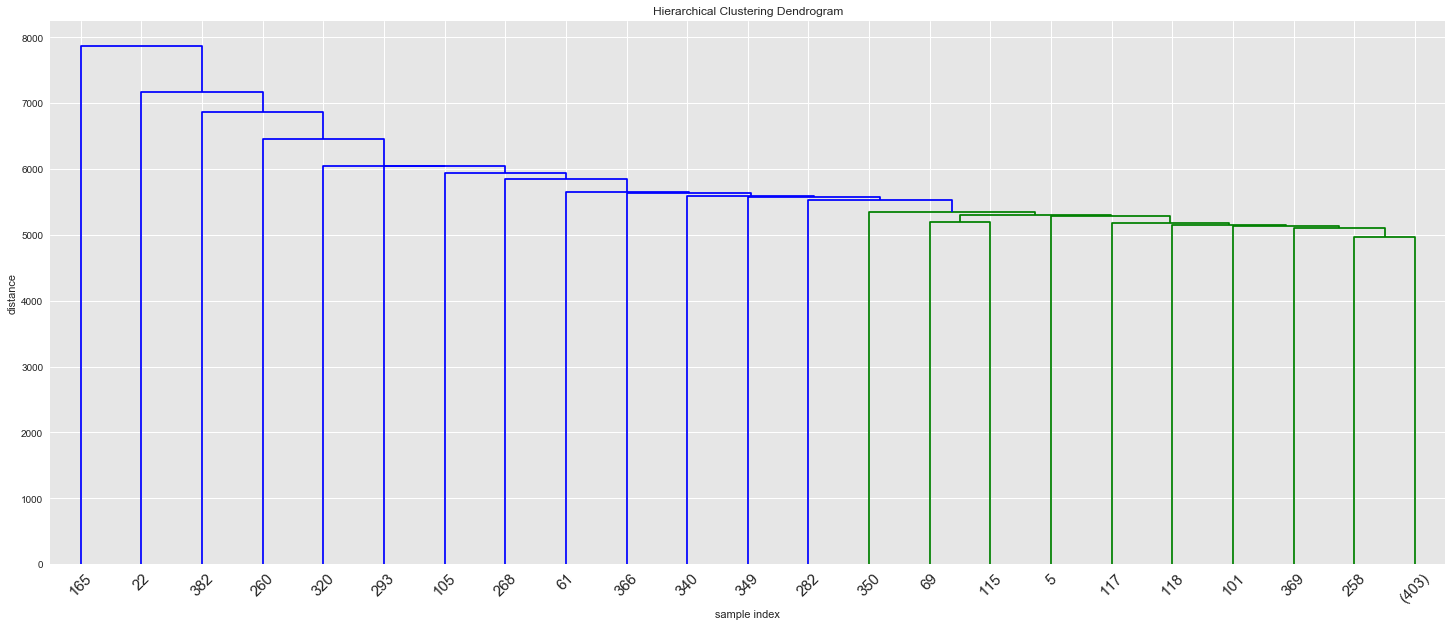

In [14]:
Z_CAH_ond7,CT_CAH_ond7 = CAH(Coeff7)
plot_dendrogram(Z_CAH_ond7)

### CAH sur les coefficients d'ondelettes de niveaux 1 à 6

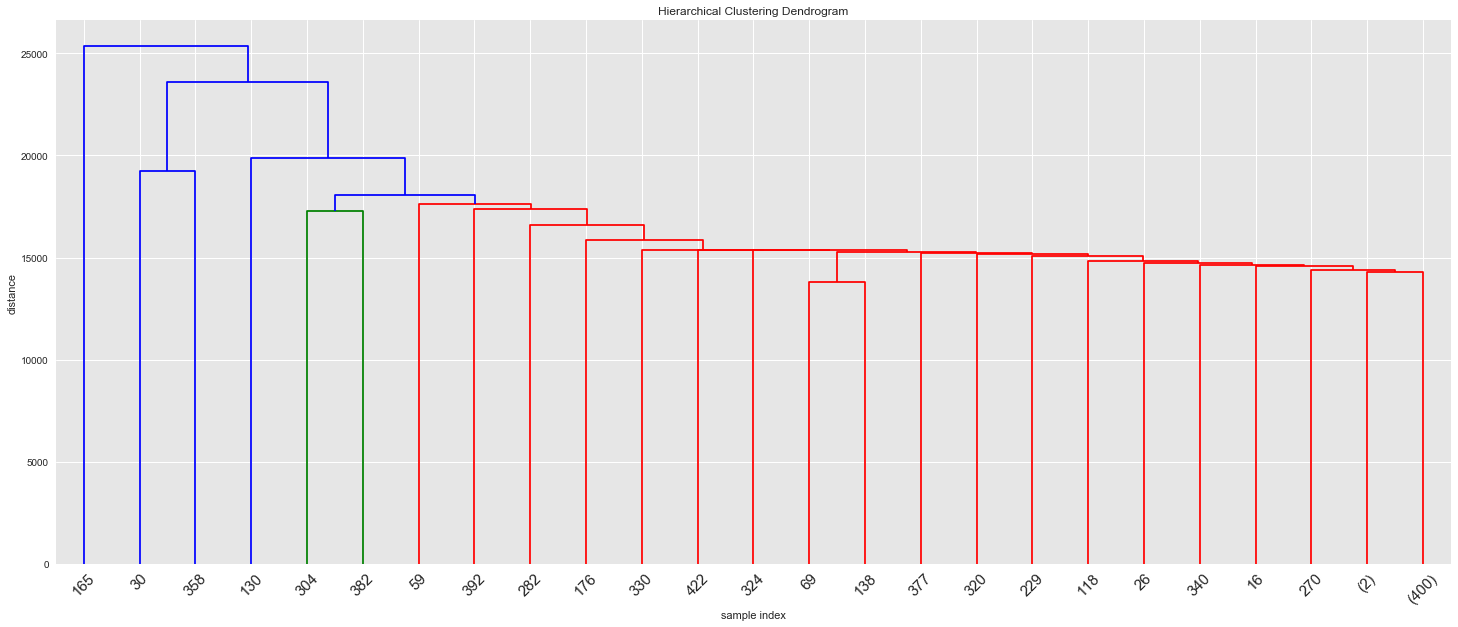

In [15]:
Z_CAH_ondA6,CT_CAH_ondA6 = CAH(CoeffA6)
plot_dendrogram(Z_CAH_ondA6)

### CAH sur les coefficients d'ondelettes de niveaux 1 à 4

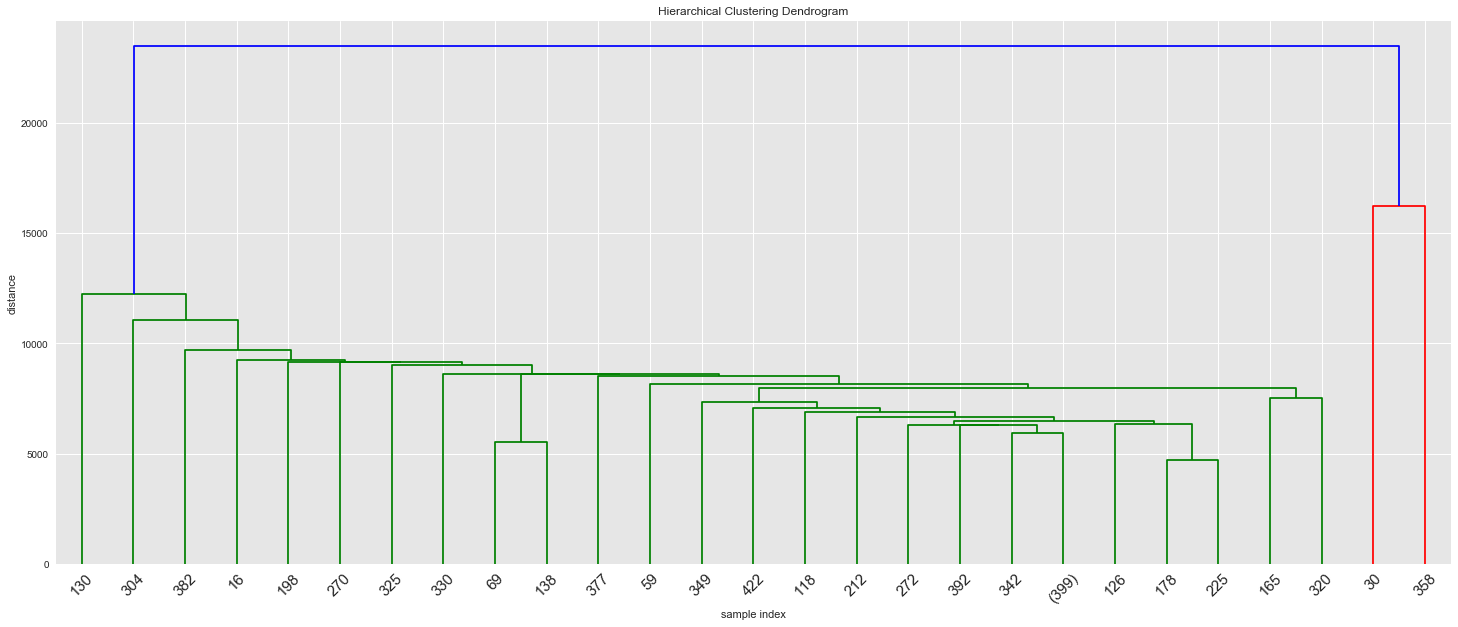

In [16]:
Z_CAH_ondA4,CT_CAH_ondA4 = CAH(CoeffA4)
plot_dendrogram(Z_CAH_ondA4)

### CAH sur les coefficients d'ondelettes seuillés

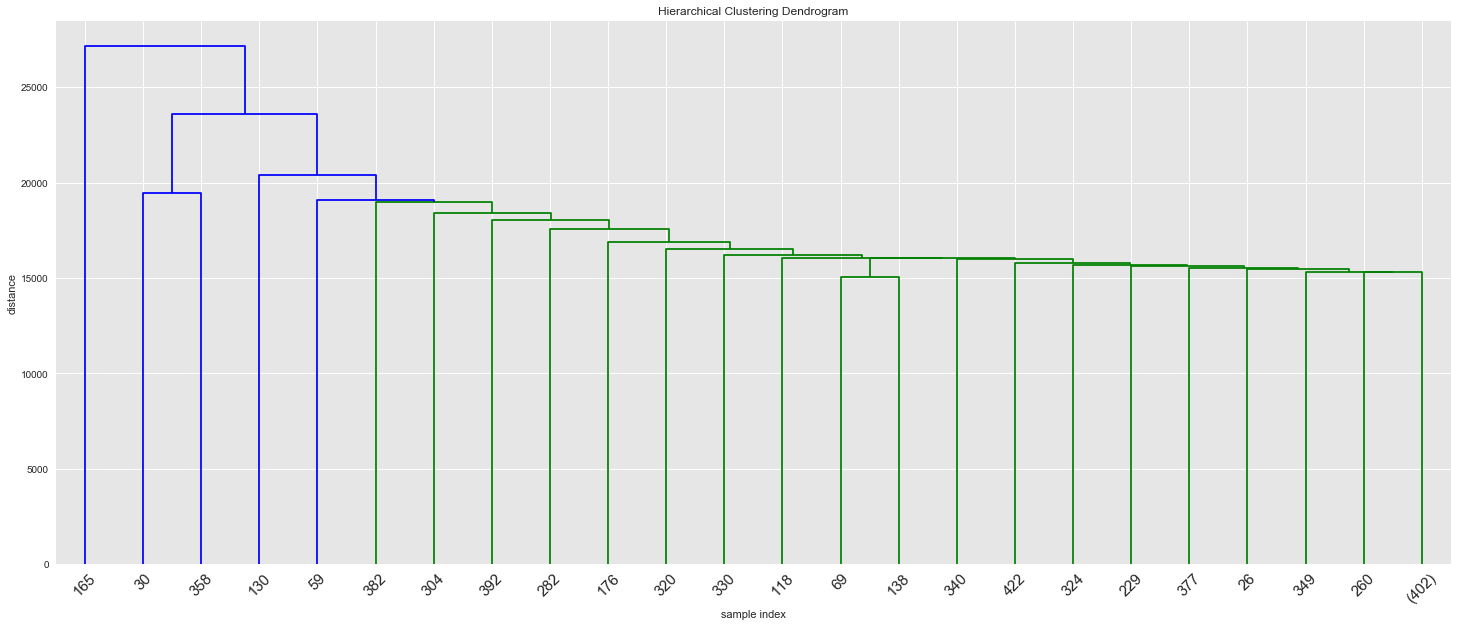

In [17]:
Z_CAH_ondT,CT_CAH_ondT = CAH(TCoeff)
plot_dendrogram(Z_CAH_ondT)

## Fonctions de visualistion des résultats

In [18]:
def make_figure(fig, ax, CT, legend=False):
    y_lim = (-1.13,1.13)
    x_lim = [-5,n+5]
    CT_Normal = CT[CT.pred==1]
    CT_Anomaly = CT[CT.pred==-1]
    
    ax.scatter(CT_Normal.index, - CT_Normal.pred, color="green", label="Normal")
    ax.scatter(CT_Anomaly.index, - CT_Anomaly.pred, color="red", label="Anomaly detected")
    
    #for x,y,s in zip(CT_Anomaly.index, - CT_Anomaly.pred, map(str,CT_Anomaly.index)):
    #    ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color="red")

    ax.plot(x_lim, [0,0], color="black")
    ax.set_xlim(*x_lim)
    ax.set_ylim(y_lim)
    
    if legend:
        plt.legend(bbox_to_anchor=(1,1), fontsize=20)

**A ADAPTER**

In [19]:
#Methode : IF, OC-SVM, LOF
#contamination : IF, LOF
#nu : OC-SVM
#n_neighbors : LOF
def level(X_acp_ond,contamination,methode): 
    xx, yy = np.meshgrid(np.linspace(X_acp_ond[:,0].min()-5, X_acp_ond[:,0].max()+5, 500), 
                         np.linspace(X_acp_ond[:,1].min()-1, X_acp_ond[:,1].max()+1, 500))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.set_title(str(methode) + ", contamination = %f" + str(contamination))
    ax.contourf(xx, yy, Z, levels=[Z.min(), clf.threshold_, Z.max()], cmap = plt.cm.PuBu)

    s = 40
    b1 = plt.scatter(X_acp_ond[:,0], X_acp_ond[:,1], c='white', s=s, edgecolors='k')
    labels=[]
    for x,y,ss,  in zip(X_acp_ond[:,0], X_acp_ond[:,1], map(str,range(n))):
        ax.scatter(x,y, c=COLOR_DIC[a],  s=s, edgecolors='k')
    plt.legend()

## Isolation Forest

In [20]:
def IF(Coeff,contamination):
    clf = se.IsolationForest(n_estimators=100, contamination=contamination, bootstrap=True, n_jobs=-1)
    clf.fit(Coeff)
    y_pred = clf.predict(Coeff)
    return pd.DataFrame(list(y_pred), columns=["pred"])

Q : QUEL CHOIX DE `contamination` (proportion d'outliers) ?

In [21]:
contamination=20/n
#Sur tous les coefficients d'ondelettes
CT_IF_ond = IF(Coeff,contamination)
#Sur les coefficients d'ondelettes de niveau le plus fin J=7
CT_IF_ond7 = IF(Coeff7,contamination)
#Sur les coefficients d'ondelettes de niveaux 0 à 6
CT_IF_ondA6 = IF(CoeffA6,contamination)
#Sur les coefficients d'ondelettes de niveaux 0 à 4
CT_IF_ondA4 = IF(CoeffA4,contamination)
#Sur les coefficients d'ondelettes seuillés
CT_IF_ondT = IF(TCoeff,contamination) 

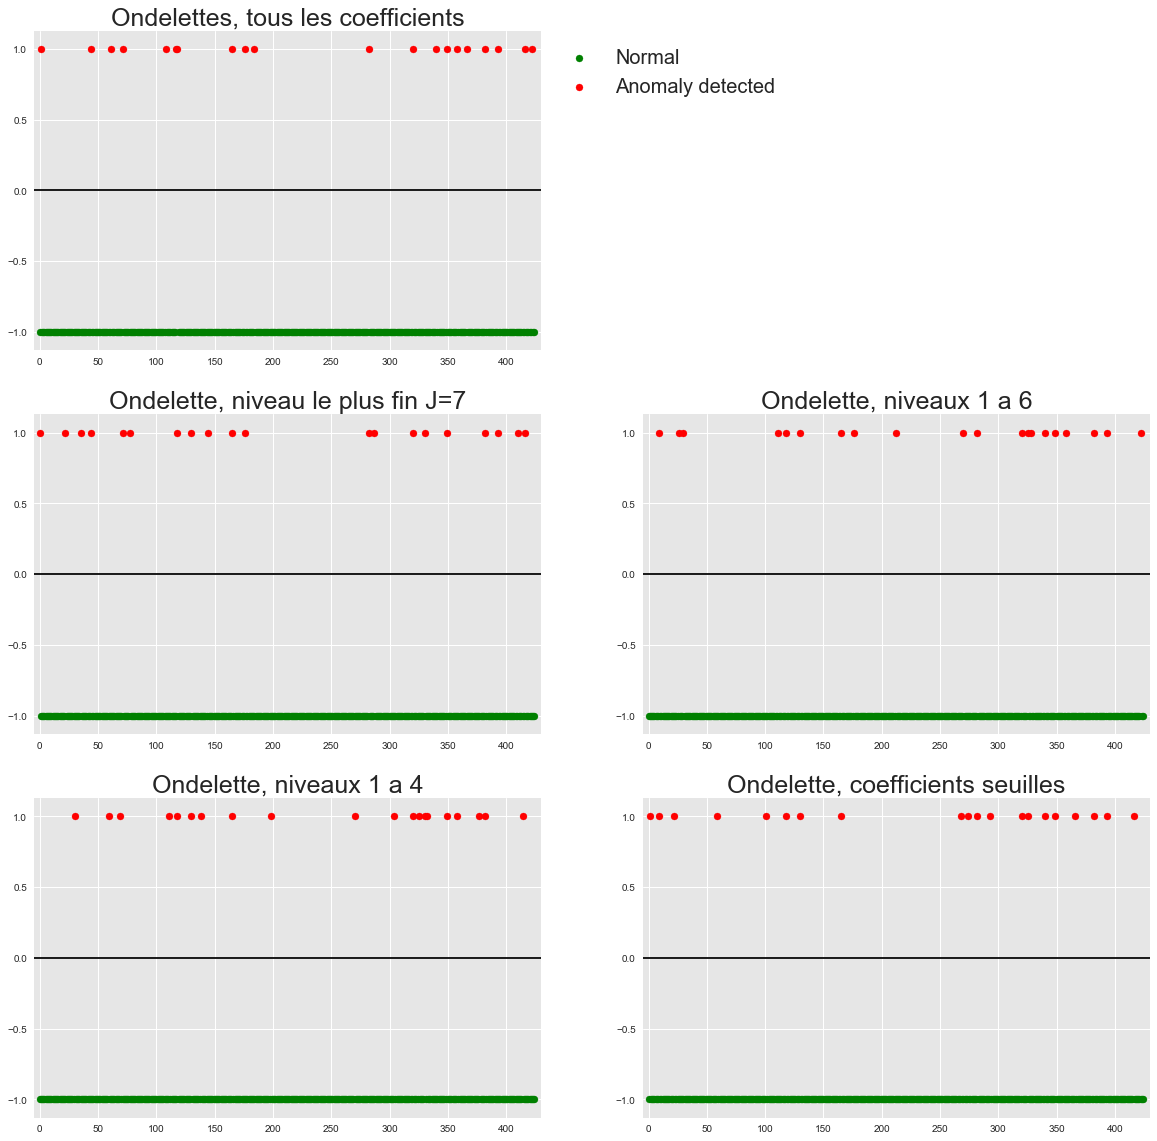

In [22]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(3,2,1)
make_figure(fig,ax,CT_IF_ond,legend=True)
ax.set_title("Ondelettes, tous les coefficients", fontsize=25)
ax = fig.add_subplot(3,2,3)
make_figure(fig,ax,CT_IF_ond7)
ax.set_title("Ondelette, niveau le plus fin J=7", fontsize=25)
ax = fig.add_subplot(3,2,4)
make_figure(fig,ax,CT_IF_ondA6)
ax.set_title("Ondelette, niveaux 1 a 6", fontsize=25)
ax = fig.add_subplot(3,2,5)
make_figure(fig,ax,CT_IF_ondA4)
ax.set_title("Ondelette, niveaux 1 a 4", fontsize=25)
ax = fig.add_subplot(3,2,6)
make_figure(fig,ax,CT_IF_ondT)
ax.set_title("Ondelette, coefficients seuilles", fontsize=25)
plt.show()

In [23]:
print("Anomalies avec tous les coefficients : ", CT_IF_ond[CT_IF_ond.pred==-1].index.values)
print("Anomalies avec coefficients de niveau le plus fin J=7: ", CT_IF_ond7[CT_IF_ond7.pred==-1].index.values)
print("Anomalies avec coefficients de niveaux 1 à 6: ", CT_IF_ondA6[CT_IF_ondA6.pred==-1].index.values)
print("Anomalies avec coefficients de niveaux 1 à 4: ", CT_IF_ondA4[CT_IF_ondA4.pred==-1].index.values)
print("Anomalies avec coefficients seuillés: ", CT_IF_ondT[CT_IF_ondT.pred==-1].index.values)

Anomalies avec tous les coefficients :  [  1  44  61  71 108 117 118 165 176 184 282 320 340 349 358 366 382 393
 416 422]
Anomalies avec coefficients de niveau le plus fin J=7:  [  0  22  35  44  71  77 118 130 144 165 176 282 287 320 330 349 382 393
 410 416]
Anomalies avec coefficients de niveaux 1 à 6:  [  9  26  30 111 118 130 165 176 212 270 282 320 325 328 340 349 358 382
 393 422]
Anomalies avec coefficients de niveaux 1 à 4:  [ 30  59  69 111 118 130 138 165 198 270 304 320 325 330 332 349 358 377
 382 414]
Anomalies avec coefficients seuillés:  [  1   9  22  59 101 118 130 165 268 274 282 293 320 325 340 349 366 382
 393 416]


## One Class SVM

In [24]:
def OCSVM(Coeff,nu):
    OCS = ssvm.OneClassSVM(kernel="rbf",nu=nu)
    OCS.fit(Coeff)
    pred = OCS.predict(Coeff)
    return pd.DataFrame(list(pred), columns=["pred"])

**AFFINER LE CHOIX DE NU + verifier comment ça marche**

In [25]:
nu=20/n
#Sur tous les coefficients d'ondelettes
CT_OCSVM_ond = OCSVM(Coeff,1-nu)
#Sur les coefficients d'ondelettes de niveau le plus fin J=7
CT_OCSVM_ond7 = OCSVM(Coeff7,1-nu)
#Sur les coefficients d'ondelettes de niveaux 0 à 6
CT_OCSVM_ondA6 = OCSVM(CoeffA6,1-nu)
#Sur les coefficients d'ondelettes de niveaux 0 à 4
CT_OCSVM_ondA4 = OCSVM(CoeffA4,1-nu)
#Sur les coefficients d'ondelettes seuillés
CT_OCSVM_ondT = OCSVM(TCoeff,1-nu)

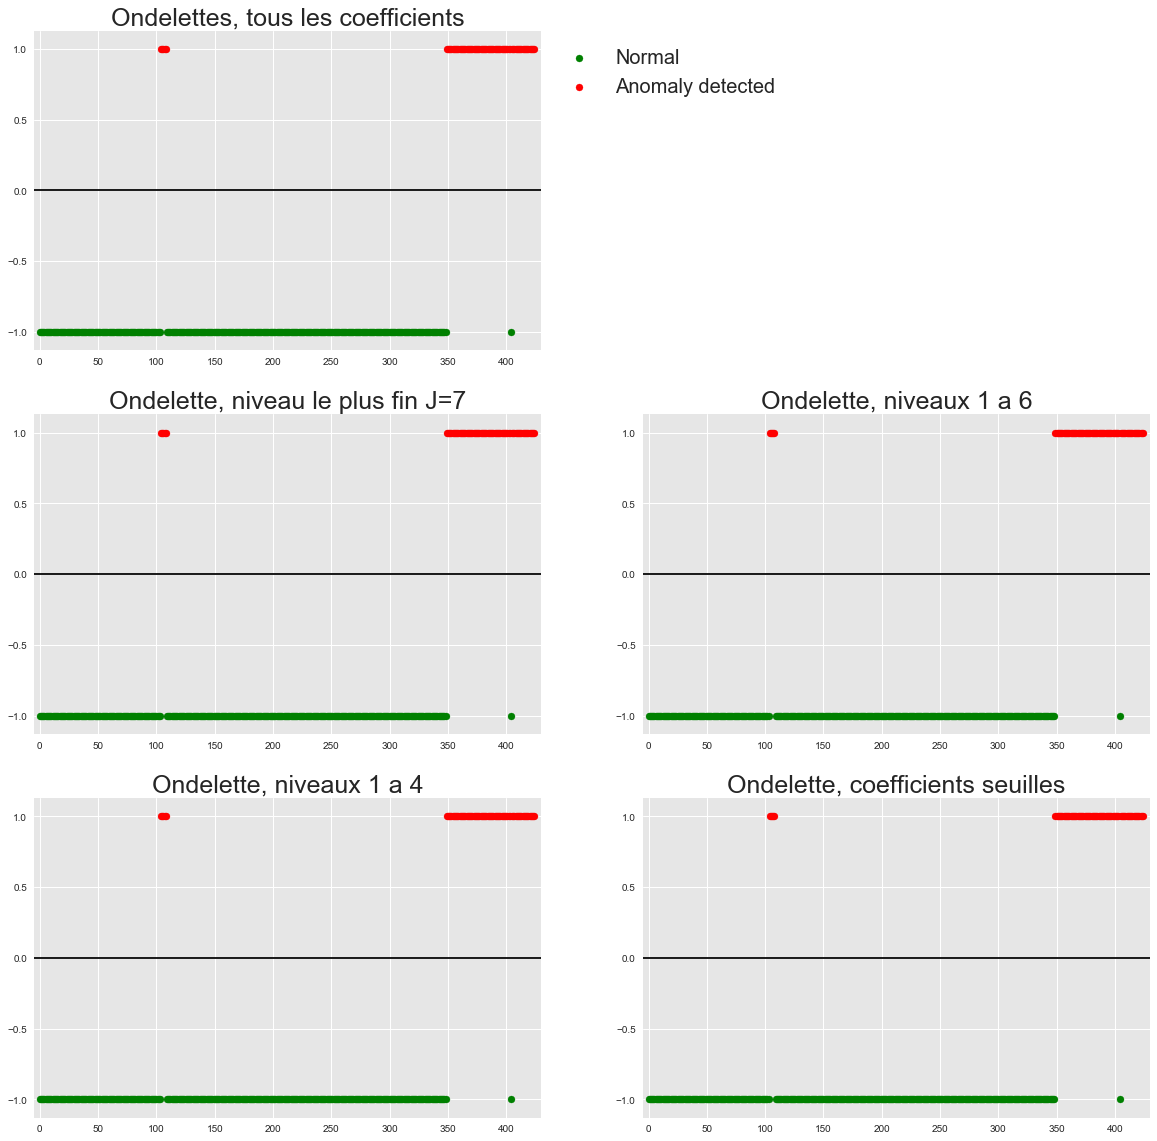

In [26]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(3,2,1)
make_figure(fig,ax,CT_OCSVM_ond,legend=True)
ax.set_title("Ondelettes, tous les coefficients", fontsize=25)
ax = fig.add_subplot(3,2,3)
make_figure(fig,ax,CT_OCSVM_ond7)
ax.set_title("Ondelette, niveau le plus fin J=7", fontsize=25)
ax = fig.add_subplot(3,2,4)
make_figure(fig,ax,CT_OCSVM_ondA6)
ax.set_title("Ondelette, niveaux 1 a 6", fontsize=25)
ax = fig.add_subplot(3,2,5)
make_figure(fig,ax,CT_OCSVM_ondA4)
ax.set_title("Ondelette, niveaux 1 a 4", fontsize=25)
ax = fig.add_subplot(3,2,6)
make_figure(fig,ax,CT_OCSVM_ondT)
ax.set_title("Ondelette, coefficients seuilles", fontsize=25)
plt.show()

In [27]:
print("Anomalies avec tous les coefficients : ", CT_OCSVM_ond[CT_OCSVM_ond.pred==-1].index.values)
print("Anomalies avec coefficients de niveau le plus fin J=7: ", CT_OCSVM_ond7[CT_OCSVM_ond7.pred==-1].index.values)
print("Anomalies avec coefficients de niveaux 1 à 6: ", CT_OCSVM_ondA6[CT_OCSVM_ondA6.pred==-1].index.values)
print("Anomalies avec coefficients de niveaux 1 à 4: ", CT_OCSVM_ondA4[CT_OCSVM_ondA4.pred==-1].index.values)
print("Anomalies avec coefficients seuillés: ", CT_OCSVM_ondT[CT_OCSVM_ondT.pred==-1].index.values)

Anomalies avec tous les coefficients :  [104 105 106 107 108 349 350 351 352 353 354 355 356 357 358 359 360 361
 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379
 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397
 398 399 400 401 402 403 405 406 407 408 409 410 411 412 413 414 415 416
 417 418 419 420 421 422 423 424]
Anomalies avec coefficients de niveau le plus fin J=7:  [104 105 106 107 108 349 350 351 352 353 354 355 356 357 358 359 360 361
 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379
 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397
 398 399 400 401 402 403 405 406 407 408 409 410 411 412 413 414 415 416
 417 418 419 420 421 422 423 424]
Anomalies avec coefficients de niveaux 1 à 6:  [104 105 106 107 108 349 350 351 352 353 354 355 356 357 358 359 360 361
 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379
 380 381 382 383 384 385 386 387 388 389 390 391 392 393 39

## Local Outlier Factor

In [32]:
def LOF(Coeff,contamination,metric,n_neighbors):
    clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric=metric)
    y_pred = clf.fit_predict(Coeff)
    return pd.DataFrame(list(y_pred), columns=["pred"])

In [33]:
contamination=20/n
metric = "euclidean"
n_neighbors = 15
#Sur tous les coefficients d'ondelettes
CT_LOF_ond = LOF(Coeff,contamination,metric,n_neighbors)
#Sur les coefficients d'ondelettes de niveau le plus fin J=7
CT_LOF_ond7 = LOF(Coeff7,contamination,metric,n_neighbors)
#Sur les coefficients d'ondelettes de niveaux 0 à 6
CT_LOF_ondA6 = LOF(CoeffA6,contamination,metric,n_neighbors)
#Sur les coefficients d'ondelettes de niveaux 0 à 4
CT_LOF_ondA4 = LOF(CoeffA4,contamination,metric,n_neighbors)
#Sur les coefficients d'ondelettes seuillés
CT_LOF_ondT = LOF(TCoeff,contamination,metric,n_neighbors)

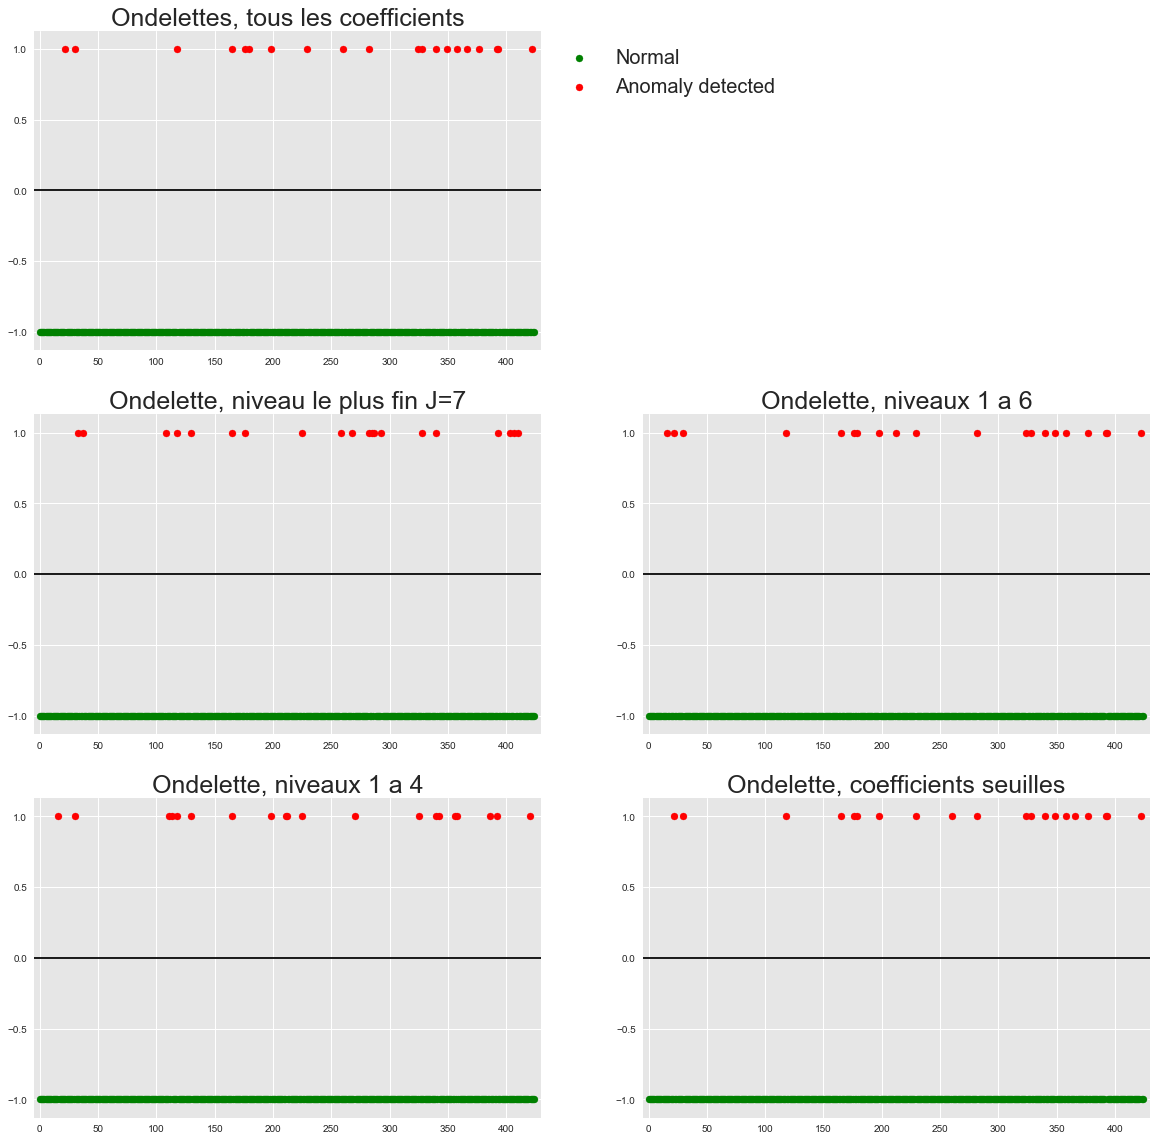

In [34]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(3,2,1)
make_figure(fig,ax,CT_LOF_ond,legend=True)
ax.set_title("Ondelettes, tous les coefficients", fontsize=25)
ax = fig.add_subplot(3,2,3)
make_figure(fig,ax,CT_LOF_ond7)
ax.set_title("Ondelette, niveau le plus fin J=7", fontsize=25)
ax = fig.add_subplot(3,2,4)
make_figure(fig,ax,CT_LOF_ondA6)
ax.set_title("Ondelette, niveaux 1 a 6", fontsize=25)
ax = fig.add_subplot(3,2,5)
make_figure(fig,ax,CT_LOF_ondA4)
ax.set_title("Ondelette, niveaux 1 a 4", fontsize=25)
ax = fig.add_subplot(3,2,6)
make_figure(fig,ax,CT_LOF_ondT)
ax.set_title("Ondelette, coefficients seuilles", fontsize=25)
plt.show()

In [35]:
print("Anomalies avec tous les coefficients : ", CT_LOF_ond[CT_LOF_ond.pred==-1].index.values)
print("Anomalies avec coefficients de niveau le plus fin J=7: ", CT_LOF_ond7[CT_LOF_ond7.pred==-1].index.values)
print("Anomalies avec coefficients de niveaux 1 à 6: ", CT_LOF_ondA6[CT_LOF_ondA6.pred==-1].index.values)
print("Anomalies avec coefficients de niveaux 1 à 4: ", CT_LOF_ondA4[CT_LOF_ondA4.pred==-1].index.values)
print("Anomalies avec coefficients seuillés: ", CT_LOF_ondT[CT_LOF_ondT.pred==-1].index.values)

Anomalies avec tous les coefficients :  [ 22  30 118 165 176 179 198 229 260 282 324 328 340 349 358 366 377 392
 393 422]
Anomalies avec coefficients de niveau le plus fin J=7:  [ 33  37 108 118 130 165 176 225 258 268 282 285 287 293 328 340 393 403
 407 410]
Anomalies avec coefficients de niveaux 1 à 6:  [ 16  22  30 118 165 176 179 198 212 229 282 324 328 340 349 358 377 392
 393 422]
Anomalies avec coefficients de niveaux 1 à 4:  [ 16  30 111 113 118 130 165 198 211 212 225 270 325 340 342 356 358 386
 392 420]
Anomalies avec coefficients seuillés:  [ 22  30 118 165 176 179 198 229 260 282 324 328 340 349 358 366 377 392
 393 422]
